# MeshGraphNets Dataset

Example of [CylinderFlow](https://github.com/google-deepmind/deepmind-research/tree/master/meshgraphnets) dataset provided by DeepMind - consists of simulations of incompressible Navier-Stokes flow trajectories over circular cyinder over time, generated using COMSOL. Dataset consists of 1200 trajectories (different simulation domains), each conisting of 600 time steps.

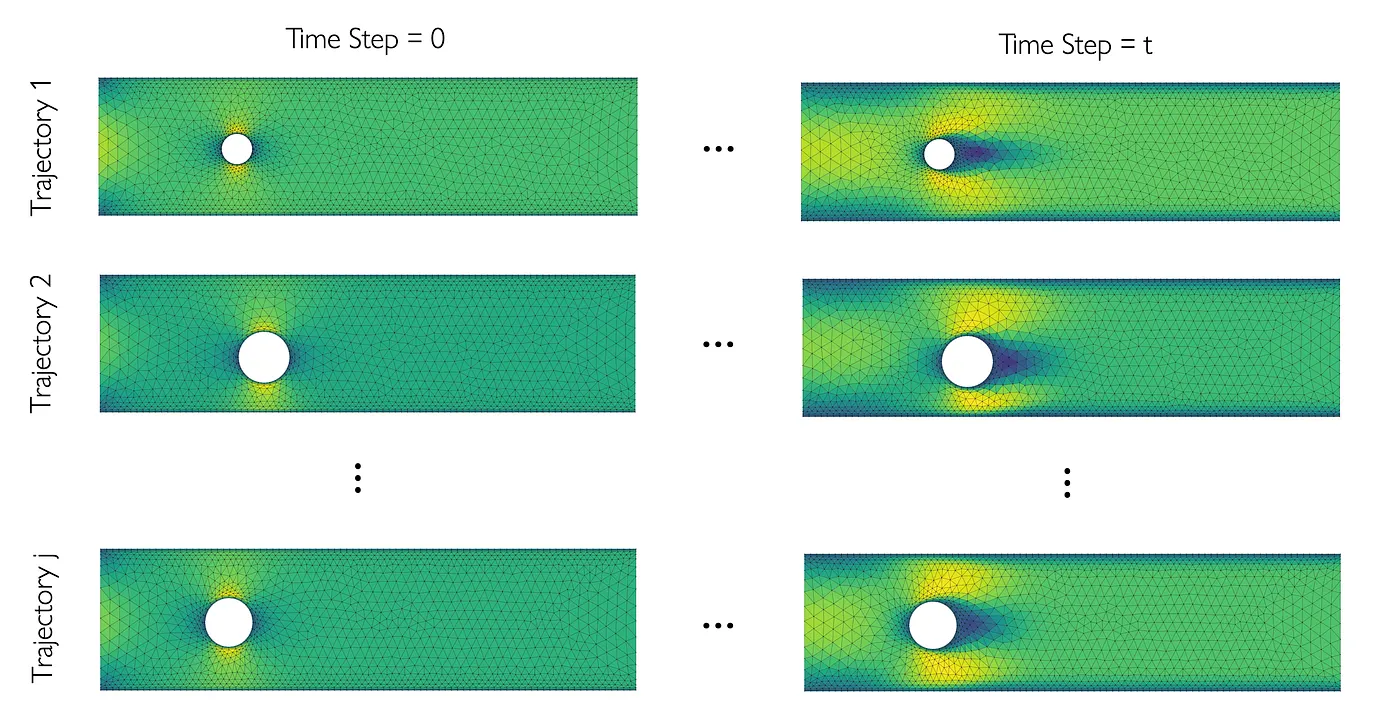

Different trajectories use different 2D triangular meshes, with edge lengths deviating throughout mesh, based on underlying structure being modelled. Data associated with each graph in dataset is:
- Node type: 9-dimensional one-hot vector corresponding to node location in fluid, wall, inflow or outflow regions
- Mesh topology: each node contains 2D position vector of its location in 2D space being simulated
- Node attributes: underlying data that I am training MeshGraphNets to simulate - dataset contains both 2D velocity vector of fluid and scalar pressure, which can be directly calculated from time-dependent velocity

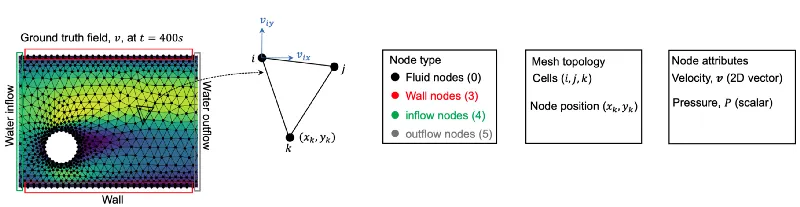

Dataset provided by DeepMind in TFRecord format - used with TensorFlow training pipelines. To train with PyG piperline - dataset pre-processed with [code available online](https://colab.research.google.com/drive/1mZAWP6k9R0DE5NxPzF8yL2HpIUG3aoDC#scrollTo=vk_4kT0BzX1O) but for now I am using example datasets to test.

In PyG - each graph is stored in an instance of torch_geometric.data.Data - stores all of attributes of graph. Preprocessor code returns list of all graphs at each time step for all trajectories used during training. 

#### Single Element Structure
A single element (ie a graph corresponding to a single time step) has the following signature:

for each node i in graph with neighbour node j:

- x = node features = contains ground truth 2D velocities concatenated with 9D node type one-hot vector for all nodes [num_nodes * 11]
- edge_index = contains connectiviy of graph in [COO](https://scipy-lectures.org/advanced/scipy_sparse/coo_matrix.html) (Coordinate Format) format [2 * num_edges]
- edge_attr = contains 2D position vector, $u_{ij}$, between connecting nodes ($u_{ij}=u_{i}-u_{j}$) concatenated with 2-norm of poistion vector [num_edges * 3]
- y = node outputs = contains fluid acceleration between current graph and graph in nect time step = features used for training [num_nodes * 2]: 
$$y=\frac{v_{t_{\text{next}}}-v_{t_{\text{curr}}}}{dt}$$
- p = pressure scalar = used for validation [num_nodes * 1]

cells and mesh_pos = attributes containing no new info - included for ease of visualisation of results

## Building MeshGraphNets

Example of dynamic forward fluid flow simulation surrogate model for a meshed domain:

Given the velocities at each nide at a time step, it predicts the acceleration at each mesh node, from which one can calculate the next step's velocities through forward integeration. The architecture of MeshGraphNets consists of encoding, processing and decoding steps.

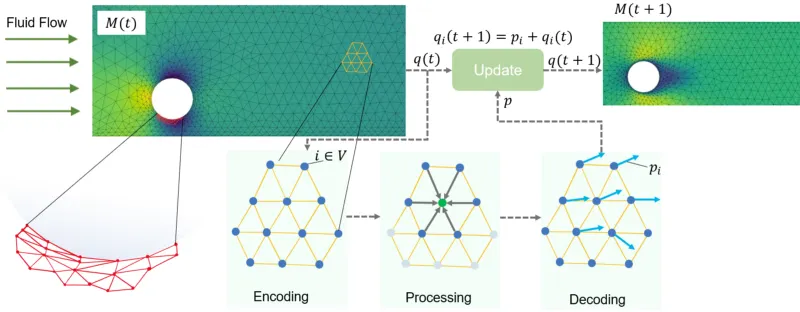

- Encoding = generates node/edge embeddings from features
- Processing = takes care of message passing, aggregating and updating
- Devoding = post-processing step that gives final predictions

### 1. Encoding

Generates node and edge embeddings from initial features of graph - train on these embeddings in processing step. 

#### Node embeddings

Initial node features of graph = concatenation of *velocity* at current time step ($w_i$) with one-hot *node type* vector ($n_i$)

Example: node's features inputted into MLP $\epsilon_v$ to get node feature $v_i$

<img src="images/image.png" width="320">

<img src="images/image copy.png" width="320">

In original MeshGraphNets study all MLPs have 2 hidden layers with ReLU activation and output layer normalised by LayerNorm (excluding decoding MLP) and each hidden layer has a size of 128.

#### Edge embeddings

Edge features = concatenation of relative *position* vector 
($u_{i,i+1}$) 
with its *norm* 
($|u_{i,i+1}|$)
inputted into a different MLP, $\epsilon_m$ to get embeddings for each edge

<img src="images/image copy 2.png" width="320">

<img src="images/image copy 3.png" width="320">

### 2. Processing (Message Passing, Aggregation, Updating)

Processing layers of MeshGraphNets handled by a separate class, ProcessorLayer, which inherits from PyG MessagePassing base class, which streamlines message passing network logic.

#### Propagation (forward function)

MessagePassing.propagate() function initiates propagation of messages. Info passed to function required for message passing and aggregations:

- COO - method of storing sparse matrices (many zero entries) by representing each non-zero value as a 'triple' of its row index, column index and value itself - efficient as only stores non-zero data

<img src="images/image copy 4.png" width="640">

- edge_index
- node embeddings = x
- feature embeddings = edge_attr

Forward function returns updated node and edge embeddings - passed into next processor layer for further processing or to decoder.

#### Message Passing (Message function)

For each directed edge ${j}\to{i}$, concatenate edge embedding $e_{ij}$ and node embeddings for its end points, $x_i$ and $x_j$ and pass result through small MLP, $f_m$. Then apply skip (residual) connection from current edge embedding:

$$
e_{ij}^′​=e_{ij}​+f_m​([e_{ij}​∥x_i​∥x_j​])
$$

ie MLP learns a correction and adds it to the original $e_{ij}$

<img src="images/image copy 5.png" width="320">

<img src="images/image copy 6.png" width="320">

These updated edge embeddings $e_{ij}^′$ are then treated as the messages that flow along edges into the receiver node i. 

In PyTorch Geometric's MessagePassing.propagate() fn call uses edge_index to gather the correct node features for each edge and hands them to message() method as $x_i$ (receiver/target) and $x_j$ (sender/source). 

Edge index has shape [2,E] in COO format. For each edge k, edge_index[0,k] = i (target) and edge_index[1,k] = j (source) so edge k is $j\to{i}$.

MessagePassing.propagate() method then facilitates calling of aggregation method, with an input of updated_edges.

#### Aggregation (Aggregate function)

1. At receiver node i, aggregate messages (updated edge embeddings) from all incoming neighbors by summing over the connected edges of each node, yielding $m_i = \text{AGG}_{j∈N(i)​}(e_{ij}^′)$. Facilitated by 

torch_scatter.scatter(src=updated_edges, index=edge_index[0,:], dim=0, reduce='sum') 

- src = thing you want to reduce, updated_edges shape [E,H]
- index = length-E vector of group IDs telling scatter where each row of source should be added (which group each row of src belongs to when it reduces) = edge_index[0,:] as want to aggregate into *targets*
- dim = 0 as grouping rows of tensor into bins according to an index vector and then reducing each bin (summing all rows that fell into the same bin)

2. Aggregate the aggregated messages from above with the self node embedding. Done after propagate() returns, in forward function: 

updated_nodes = torch.cat([x,out],dim=1)

<img src="images/image copy 7.png" width="320">

<img src="images/image copy 8.png" width="320">

#### Updating

Pass final result from aggregation for each node into an MLP with a skip connection, $f_v$. Done at end of forward function:

updated_nodes = x + self.node_mlp(updated_nodes)

<img src="images/image copy 9.png" width="320">

### 3. Decoding

Final accelerations for each node i, $p_i$ found by passing final node embeddings ${v_i}^{'}$ through decoding MLP $\delta_v$.

<img src="images/image copy 10.png" width="320">


## Importing libraries and datasets

In [ ]:
import torch
import random
import os
import pandas as pd
import torch_scatter
import torch.nn as nn
from torch.nn import Linear, Sequential, LayerNorm, ReLU
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.data import DataLoader
from torch_geometric.data.storage import GlobalStorage
import numpy as np
import time
import torch.optim as optim
from tqdm import trange
import copy
import matplotlib.pyplot as plt
import h5py
#import tensorflow.compat.v1 as tf
import functools
import json
from torch_geometric.data import Data
import enum

In [ ]:
root_dir = os.getcwd()
dataset_dir = os.path.join(root_dir, 'data')
checkpoint_dir = os.path.join(root_dir, 'best_models')
postprocess_dir = os.path.join(root_dir, 'animations')

file_path = os.path.join(dataset_dir,'meshgraphnets_miniset5traj_vis.pt')
torch.serialization.add_safe_globals([GlobalStorage])
dataset_timesteps = torch.load(file_path, weights_only=False)
dataset = torch.load(file_path)[:1]

print(dataset)

[Data(x=[1923, 11], edge_index=[2, 11070], edge_attr=[11070, 3], y=[1923, 2], p=[1923, 1], cells=[3612, 3], mesh_pos=[1923, 2])]


### Normalisation

Normalisation necessary for features and output params: mean = 0, std = 1 = variance, to stabilise training. 

In [ ]:
def normalise(to_normalise,mean_vec,std_vec):
    return (to_normalise-mean_vec)/std_vec

def unnormalise(to_unnormalise,mean_vec,std_vec):
    return to_unnormalise*std_vec+mean_vec

def get_stats(data_list):
    '''
    Method for normalizing processed datasets. Given  the processed data_list,
    calculates the mean and standard deviation for the node features, edge features,
    and node outputs, and normalises these using the calculated statistics.
    '''

    #mean and std of the node features are calculated
    mean_vec_x=torch.zeros(data_list[0].x.shape[1:])
    std_vec_x=torch.zeros(data_list[0].x.shape[1:])

    #mean and std of the edge features are calculated
    mean_vec_edge=torch.zeros(data_list[0].edge_attr.shape[1:])
    std_vec_edge=torch.zeros(data_list[0].edge_attr.shape[1:])

    #mean and std of the output parameters are calculated
    mean_vec_y=torch.zeros(data_list[0].y.shape[1:])
    std_vec_y=torch.zeros(data_list[0].y.shape[1:])

    #Define the maximum number of accumulations to perform such that we do
    #not encounter memory issues
    max_accumulations = 10**6

    #Define a very small value for normalizing to
    eps=torch.tensor(1e-8)

    #Define counters used in normalization
    num_accs_x = 0
    num_accs_edge=0
    num_accs_y=0

    #Iterate through the data in the list to accumulate statistics
    for dp in data_list:

        #Add to the
        mean_vec_x+=torch.sum(dp.x,dim=0)
        std_vec_x+=torch.sum(dp.x**2,dim=0)
        num_accs_x+=dp.x.shape[0]

        mean_vec_edge+=torch.sum(dp.edge_attr,dim=0)
        std_vec_edge+=torch.sum(dp.edge_attr**2,dim=0)
        num_accs_edge+=dp.edge_attr.shape[0]

        mean_vec_y+=torch.sum(dp.y,dim=0)
        std_vec_y+=torch.sum(dp.y**2,dim=0)
        num_accs_y+=dp.y.shape[0]

        if(num_accs_x>max_accumulations or num_accs_edge>max_accumulations or num_accs_y>max_accumulations):
            break

    mean_vec_x = mean_vec_x/num_accs_x
    std_vec_x = torch.maximum(torch.sqrt(std_vec_x/num_accs_x - mean_vec_x**2),eps)

    mean_vec_edge = mean_vec_edge/num_accs_edge
    std_vec_edge = torch.maximum(torch.sqrt(std_vec_edge/num_accs_edge - mean_vec_edge**2),eps)

    mean_vec_y = mean_vec_y/num_accs_y
    std_vec_y = torch.maximum(torch.sqrt(std_vec_y/num_accs_y - mean_vec_y**2),eps)

    mean_std_list=[mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y]

    return mean_std_list

## Building Model

### Encoder
Preprocessing step to GNN blocks (processor). Have two separate encoders for edges and nodes. Encoders generate node and edge embeddings from initial features of graph. 

Initial node embeddings = concatenated (velocity at specific time step) with (one-hot node type vector). 

Initial edge embeddings = concatenation of (relative position vector) with (norm of relative position vector)

Encoding function = MLP with ReLU activation normalised by LayerNorm. 

Node encoding:
$$
\mathbf{z}_{i} = \textrm{MLP} ( \mathbf{h}_{i}) \;  ~~~~ \forall ~ i \in V
$$

Edge encoding:
$$
\mathbf{z}_{ij} = \textrm{MLP} ( \mathbf{h}_{ij}) \; ~~~~     \forall ~ \text{edges} \in E
$$

### Processor
Handles GNN message passing, aggregating and update part of architecture. Takes graph with new features generated by encoder through GNN pipeline: message, aggregation and updates for number of layers chosen. Processing layers of MeshGraphNets handled by separate class, ProcessorLayer, which inherits from PyG MessagePassing base class. 

Message = learned transformation of MLP -> concatenation of (skip connection on self edge embedding) with (embeddings of connecting nodes)

Aggregation done in 2 steps:
1. sum over connected edges of each node
2. another MLP transformation of concatenation of (edge sum) with (self node)

### Decoder
Postprocessing step that takes node updates from processor and maps it into a change in velocity/acceleration using another separately learnt MLP.

In [ ]:
class MeshGraphNet(torch.nn.Module):
    def __init__(self,in_dim_node,in_dim_edge,hid_dim,out_dim,args,emb=False):
        super().__init__()

        """
        MeshGraphNet model built on Deepmind paper https://arxiv.org/pdf/2010.03409. 
        Model consists of: (1) Preprocessing = encoder, (2) Processor, (3) Postprocessing = decoder.
        Encoder has one edge and one node decoder, processor has 2 processors for edge and 2 for nodes. Decoder is only for nodes.
        Note: edge attributes have to be updated first.

        in_dim: dynamic variables, node_type, node_position
        hid_dim: 128 (in deepmind paper)
        out_dim: dynamic variables = velocity changes
        """

        self.num_layers = args.num_layers
        assert (self.num_layers >=1), 'Num of message passing layers not >=1'

        # encoder converts raw inputs into embeddings w [hidden dimension] level representation

        self.node_encoder = Sequential(
            Linear(in_dim_node, hid_dim),
            ReLU(),
            Linear(hid_dim,hid_dim),
            LayerNorm(hid_dim)
            )
        
        self.edge_encoder = Sequential(
            Linear(in_dim_edge,hid_dim),
            ReLU(),
            Linear(hid_dim,hid_dim),
            LayerNorm(hid_dim)
        )

        # params in ModuleList tracked by PyTorch eg optimisers, to(device), train/eval, checkpoints etc
        # equivalent to an empty list (self.processor = []) but can be used/controlled in future
        self.processor = nn.ModuleList()
        processor_layer = self.build_processor_model()

        # add processor layer for every input layer
        for i in range(self.num_layers):
            self.processor.append(
                processor_layer(hid_dim,hid_dim)
            )
        
        # decoder only for node embeddings
        self.decoder = Sequential(
            Linear(hid_dim,hid_dim),
            ReLU(),
            Linear(hid_dim,out_dim)
        )
    
    def build_processor_model(self):
        return ProcessorLayer
    
    def forward(self,data,
                mean_vec_x,std_vec_x,
                mean_vec_edge,std_vec_edge):
        """
        Encoder encodes graph (node/edge features) into hidden (latent) vectors (node/edge embeddings)
        Output from processor is fed into process
        
        """

        x = data.x
        edge_index = data.edge_index
        edge_attr = data.edge_attr
        pressure = data.p

        x = normalise(
            to_normalise = x,
            mean_vec = mean_vec_x,
            std_vec = std_vec_x)

        edge_attr = normalise(
            to_normalise = edge_attr,
            mean_vec = mean_vec_edge,
            std_vec = std_vec_edge
        ) 

        # step 1 = encode node.edge features into hidden (latent) node/edge embeddings
        x = self.node_encoder(x) # output dim = hidden dim
        edge_attr = self.edge_encoder(edge_attr) # output dim = hidden dim

        # step 2 = perform message passing with hidden (latent) node/edge embeddings
        for i in range(self.num_layers):
            x, edge_attr = self.processor[i](x, edge_index, edge_attr)
    
        # step 3 = decode hidden node embeddings into physical quantities of interest
        final_x = self.decoder(x)

        return final_x
    
    def loss(self,pred,inputs,mean_vec_y,std_vec_y):
        """ 
            pred = model outputs per node, shape [N, Dy] eg Dy=2 for d(v_x)/d(v_y)
            inputs.y = ground truth targets per node, shape [N, Dy]
            inputs.x = node features, shape [N, Dx]
                inputs.x[:,:2] = velocities
                inputs.x[:,2:] = one-hot node-type vector
            mean_vec_y, std_vec_y = dataset stats for targets (not inputs) used for z-score normalisation
        """

        # define node types that calculate loss for
        normal = torch.tensor(0)
        print(f"normal: {normal}")
        outflow = torch.tensor(5)
        print(f"normal: {outflow}")

        node_types = inputs.x[:,2:].argmax(dim=1)
        print(node_types)

        # get loss mask for nodes of types that we calculate loss for
        loss_mask = torch.logical_or(
            (torch.argmax(node_types) == normal),
            (torch.argmax(node_types) == outflow)
        )

        # normalise labels with dataset statistics
        labels = normalise(inputs.y,mean_vec_y,std_vec_y)

        # sum of square errors
        error = torch.sum(((labels=pred)**2),axis=1)

        # root and mean errors for nodes we calculate loss for (loss_mask)
        loss = torch.sqrt(torch.mean(error[loss_mask]))

        return loss

### ProcessorLayer Class

ProcessorLayer inherits from [PyG MessagePassing base class](https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html) and handles processor/GNN part of architecture. Processor class serves as GNN layers composed of message passing, aggregation and updating - updating info at each layer of computational graph for each node.

#### Message Passing / Neighborhood Aggregation

Generalising the convolution operator to irregular domains is typically expressed as a *neighborhood aggregation* (message passing) scheme. Message passing GNNs can be described as:

$$
\mathbf{x}_i^{(k)}
=
\gamma^{(k)}\!\left(
\mathbf{x}_i^{(k-1)},
\;\bigoplus_{j \in \mathcal{N}(i)}
\phi^{(k)}\!\left(
\mathbf{x}_i^{(k-1)},\;
\mathbf{x}_j^{(k-1)},\;
\mathbf{e}_{j,i}
\right)
\right)
$$

- $\mathbf{x}_i^{(k-1)} \in \mathbb{R}^{F}$ are node features of node $i$ at layer $k\!-\!1$.
- $\mathbf{e}_{j,i} \in \mathbb{R}^{D}$ are (optional) edge features from node $j$ to node $i$.
- $\bigoplus$ is a differentiable, permutation-invariant aggregation (e.g., $\text{sum}$, $\text{mean}$, $\text{max}$).
- $\gamma$ and $\phi$ are differentiable functions (often $\text{MLPs}$).

#### MessagePassing Base Class

Automatically takes care of message propagation - user has to define functions $\phi$ = message() and $\gamma$ = update(), and aggregation scheme to use, aggr="add"/"mean"/"max".

Following prototype of base class - need to implement 3 main methods - message passing, aggregating and updating. 

#### Message Passing

Initiated by propagate function - message function calculates messages, m, for edge u at layer l with function MSG given previous embeddings $h_u$:

$$
m_u^{(\ell)} \;=\; \mathrm{MSG}^{(\ell)}\!\big(h_u^{(\ell-1)}\big)
$$

For MeshGraphNets - messages are calculated for edges and passed to nodes so MSG function takes edge embeddings and adjacent node embeddings and concatenates them. These concatenated previous embeddings make up $h_u$ and are put through an MLP (the MSG fn) to give the final messages $m_u$, which are passed to the aggregate function.

#### Aggregation

Aggregation takes updated edge embeddings and aggregates them over the connectivity matrix (which nodes connected to which other nodes) using sum reduction. In PyG - do not build dense N x N matrix, but store it sparsely as edge_index (indices of non-zeroes in adjacency matrix) of shape [2,E] where each column is an edge ($u \to v$).

During a processor layer - first compute a message per edge:

$$
m_{u \to v}^{(\ell)}
= f_{\text{edge}}\!\left(
x_u^{(\ell-1)},\;
x_v^{(\ell-1)},\;
e_{u \to v}^{(\ell-1)}
\right)
$$

Aggregation step collects all messages that land on same target node $v$ and reduces them with a sum (PyG's propagate and aggr="add" do a scatter-sum: for each edge column in edge_index, add its message into the row of its destination node)

$$
h_v^{(\ell)} \;=\;
\mathrm{AGG}^{(\ell)}\!\Big(\{\, m_{u \to v}^{(\ell)} \mid u \in \mathcal{N}(v) \,\}\Big)
\;=\;
\sum_{u \in \mathcal{N}(v)} m_{u \to v}^{(\ell)}.
$$

For MeshGraphNets, aggregation (AGG) for node v is sum over neighbour nodes - but there is also an additional aggregation step: aggregating with the self embeddnigs. This is done outside of the aggregation function, in the forward function after the return of the propagate:

$$
h_v^{(\ell)} \;=\; \Big\{\, h_v^{(\ell-1)}\,,\; \mathrm{AGG}^{(\ell)}\!\big(\{\, m_u^{(\ell)} \mid u \in \mathcal{N}(v) \,\}\big) \,\Big\}
$$

#### Updating

Nodes embeddings finally updated by passing $h_v^{(\ell)}$ through node MLP with a skip (residual) connection = add layer's input back to its output. 

$$
m_v \;=\; \sum_{u \in \mathcal{N}(v)} m_{u \to v},
\qquad
h_v^{\text{in}} \;=\; h_v^{(\ell-1)}.
$$

$$
\tilde{h}_v \;=\; \mathrm{MLP}\!\big([\,h_v^{\text{in}},\, m_v\,]\big),
\qquad
h_v^{(\ell)} \;=\; h_v^{\text{in}} + \tilde{h}_v.
$$



This process is generally written as:

$$
h_v^{(\ell)} \;=\; \mathrm{Processor}\!\big(h_v^{(\ell)}\big)
$$

where Processor = MLP in this case.

### Edge and Node MLP

Define edge MLP layer and node MLP layer where both MLPs have same hidden dimension (out_channels) and layer structures: 2 linear layers, 1 non-linear ReLU layer and a norm layer, but input dimensions are different:

#### Edge MLP

Edge MLP takes 2 connecting node embeddings and edge embedding of itself - input dimension = 3H (H = hidden dimension). 

Inputs =  [$h_u$,$h_v$,$e_{u \to v}$] = [source node, target node, current edge]

#### Node MLP

Node MLP takes aggregated messages from its surrounding edges and the self node embeddings - input dimension = 2H. 

Inputs = [$h_v$, $\mathrm{AGG}\!\left(\{\, m_{u \to v} \,\}\right)$] = [self node state, summed neighbour message]

In [ ]:
# param named **kwargs = collect any extra keyword arguments into a dict called kwargs
# extra keywords, aggre, node_dim etc forwarded to MessagePassing.__init__ which, in PyG accepts options eg: aggr="add"


class ProcessorLayer(MessagePassing):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        """
            in_channels = dim of node embeddings [128]
            out_channels = dim of edge embeddings [128]

            constraints mean that out_channels == in_channels as:
                - concatenation input to first Linear is 3*in_channels
                    edge_attr must have in_channels features so that: 
                    2*in_channels (x_i,x_j) + in_channels (edge_attr) = 3*in_channels
                - residual add + edge_attr requires:
                    edge_attr.shape[1] == out_channels

            so:
                inputs = x: [N,H], edge_attr: [E,H] 
                outputs =  updated_nodes: [N,H], updated_edges: [E,H]

        """

        self.edge_mlp = Sequential(
            Linear(3*in_channels, out_channels),
            ReLU(),
            Linear(out_channels,out_channels),
            LayerNorm(out_channels))
        
        self.node_mlp = Sequential(
            Linear(2*in_channels,out_channels),
            ReLU(),
            Linear(out_channels,out_channels),
            LayerNorm(out_channels)
        )

        self.reset_parameters()
    
    def reset_parameters(self):
        """reset params for stacked MLP layers"""
        # index 1 (ReLU) and 3 (LayerNorm) have no params to reset
        # nn.Linear.reset_parameters() reinitialises weights and bias in place using Pytorch default scheme
        self.edge_mlp[0].reset_parameters()
        self.edge_mlp[2].reset_parameters()

        self.node_mlp[0].reset_parameters()
        self.node_mlp[2].reset_parameters()

    def forward(self, x, edge_index, edge_attr, size=None):
        """
            - handles pre and post-processing of node features/embeddings
            - initiates messages passing by calling propagate function

            x shape = [node_num, in_channels] (in_channels = dim of node embeddings)
            edge_index = [2, edge_num] (edge_num = E)
            edge_attr = [edge_num, in_channels]

        propagate = PyG function inherited from MessagePassing Base Class - PyG automatically builds tensor for message(...)
            as pass x=x, for each directed edge (j -> i) framework supplies:
                x_i (target-node features per edge)
                x_j (source-node features per edge) 
            to message(...) accroding to flow direction given to MessagePassing.__init__ via **kwargs
            
            edge_attr forwarded as-is to message(...)

        propagate then calls message(...), takes its return (updated_edges), feeds it into aggregate(...) then to update(...)

        """

        out, updated_edges = self.propagate(edge_index, x=x, edge_attr=edge_attr, size=size) # (N,out_channels), (E,out_channels)
        updated_nodes = torch.cat([x, out],dim=1) #complete aggregation through self-aggregation
        updated_nodes = x + self.node_mlp(updated_nodes) #residual connection
        return updated_nodes, updated_edges
    
    def message(self, x_i, x_j, edge_attr):
        """
        message() operates in 'edge space' - when call propagate(..) PyG lifts node features to edges by gathering appropriate rows of x
        for each edge (j -> i) it creates:
            source_node = x_i = x[edge_index[1]], shape [E, in_channels]
            target_node = x_j = x[edge_index[0]], shape [E, in_channels]
            
        target_edge: edge_attr shape [E, out_channels]
        
        messages that are passed are raw embbeddings - not processed
        """
        # concatenate x_i (target-node embedding for this edge), x_j (source-node embedding), edge_attr (current edge features)
        updated_edges = torch.cat([x_i,x_j,edge_attr],dim=1) # [E, 3*in_channels]
        
        # passes through edge_mlp: Linear -> ReLU -> Linear -> LayerNorm
        updated_edges = self.edge_mlp(updated_edges) 
        
        # residual on edges - update each edge feature by adding back its previous value (like ResNet skip connection but applied to edge embeddings instead of node embeddings)
        # new edge = edge learned update (mlp) + residual (edge_attr)
        # stablises training and helps gradiet flow in deep stacks of processor layers
        updated_edges += edge_attr 

        return updated_edges # [E, out_channels]

    def aggregate(self, updated_edges, edge_index, dim_size = None):
        """
        1. aggregregate from neighbours (adjacent nodes) through concatenation
        2. aggregate self message (from node itself)

        receives edge-wise updated_edges [E,out] from message, reduces them into a node-wise tensor via torch_scatter.scatter
            second argument in torch_scatter.scatter = index of node that each edge contributes to
        """
        # axis = 0 along which to index number of nodes so dim=0
        out = torch_scatter.scatter(updated_edges, edge_index[0,:], dim=0, reduce='sum')
        return out, updated_edges
